# Elementos de redes de onda, o El Hacedor parte IV

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://github.com/DanteNoguez/CalculusRatiocinator/raw/main/data/nombres.txt

In [3]:
nombres = open('nombres.txt', 'r').read().splitlines()
nombres[:8]

['maria', 'rosa', 'jose', 'carmen', 'ana', 'juana', 'antonio', 'elena']

In [4]:
len(nombres)

21029

In [5]:
V = sorted(set(''.join(nombres)))
paf = {p:f+1 for f, p in enumerate(V)}
paf['.'] = 0
fap = {f:p for p,f in paf.items()}
print(fap)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
nombres[:3]

['maria', 'rosa', 'jose']

In [7]:
block_size = 8 # longitud del contexto
def construir_dataset(nombres):
  X, Y = [], []
  for n in nombres:
    #print(f'nombre: {n}')
    contexto = [0] * block_size
    for c in n + '.':
      ix = paf[c]
      X.append(contexto)
      Y.append(ix)
      #print(''.join(fap[i] for i in contexto), '----> ', fap[ix])
      contexto = contexto[1:] + [ix]
  
  X = torch.tensor(X) # contexto
  Y = torch.tensor(Y) # objetivo
  return X, Y

In [36]:
construir_dataset(nombres[:2])

nombre: maria
........ ---->  m
.......m ---->  a
......ma ---->  r
.....mar ---->  i
....mari ---->  a
...maria ---->  .
nombre: rosa
........ ---->  r
.......r ---->  o
......ro ---->  s
.....ros ---->  a
....rosa ---->  .


(tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0, 13],
         [ 0,  0,  0,  0,  0,  0, 13,  1],
         [ 0,  0,  0,  0,  0, 13,  1, 18],
         [ 0,  0,  0,  0, 13,  1, 18,  9],
         [ 0,  0,  0, 13,  1, 18,  9,  1],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0, 18],
         [ 0,  0,  0,  0,  0,  0, 18, 15],
         [ 0,  0,  0,  0,  0, 18, 15, 19],
         [ 0,  0,  0,  0, 18, 15, 19,  1]]),
 tensor([13,  1, 18,  9,  1,  0, 18, 15, 19,  1,  0]))

In [8]:
import random
random.shuffle(nombres)
n1 = int(0.8*len(nombres))
n2 = int(0.9*len(nombres))

Xtr, Ytr = construir_dataset(nombres[:n1])
Xdev, Ydev = construir_dataset(nombres[n1:n2])
Xte, Yte = construir_dataset(nombres[n2:])
X, Y = construir_dataset(nombres)

X.shape, Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([165469, 8]),
 torch.Size([132348, 8]),
 torch.Size([16650, 8]),
 torch.Size([16471, 8]))

In [9]:
emb_dim = 10 # cada embedding tendrá 10 dimensiones
h = 200 # cada capa tendrá 200 unidades (hidden units)
vocab_size = len(fap) #tamaño del vocabulario

Como breve recordatorio, entrenemos nuestra red neuronal y veamos cómo lucía nuestra función de pérdida en nuestra lección anterior:

### PyTorch



In [16]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim ==3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [22]:
emb_dim = 24 # cada embedding tendrá 10 dimensiones
block_size = 8
h = 128 # cada capa tendrá 200 unidades (hidden units)
vocab_size = len(fap) #tamaño del vocabulario
batch_size = 32


model = Sequential([
    Embedding(vocab_size, emb_dim),
    FlattenConsecutive(2), Linear(emb_dim * 2, h, bias=False), BatchNorm1d(h), Tanh(),
    FlattenConsecutive(2), Linear(h * 2, h, bias=False), BatchNorm1d(h), Tanh(),
    FlattenConsecutive(2), Linear(h * 2, h, bias=False), BatchNorm1d(h), Tanh(),
    Linear(h, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

76579


In [23]:
perdida_i = []
ud = []
max_steps = 10000

for i in range(max_steps):
  #minibatch («minilote»)
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # propagación hacia delante
  logits = model(Xb)
  perdida = F.cross_entropy(logits, Yb)
  
  # propagación hacia atrás
  for p in parameters:
    p.grad = None
  perdida.backward()

  # actualización
  lr = 0.1 if i < 5000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # estadísticas
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {perdida.item():.4f}')
  perdida_i.append(perdida.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/  10000: 3.2910
   1000/  10000: 2.0020
   2000/  10000: 1.8922
   3000/  10000: 1.7809
   4000/  10000: 1.7312
   5000/  10000: 2.2390
   6000/  10000: 2.0523
   7000/  10000: 1.4820
   8000/  10000: 1.5996
   9000/  10000: 2.0324


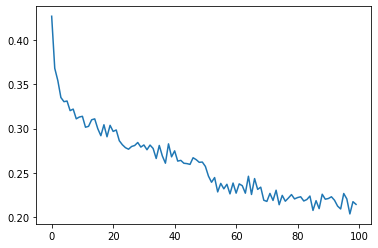

In [24]:
plt.plot(torch.tensor(perdida_i).view(-1, 100).mean(1))

In [25]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [26]:
for layer in model.layers:
  layer.training = False

In [27]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 1.63508939743042
val 1.6731863021850586
test 1.708795189857483


In [30]:
block_size = 8
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(fap[i] for i in out))

grividos.
santo.
yrenco.
freulh.
romana.
ronusa.
flariz.
porcidil.
baduida.
elisia.
haide.
bani.
osgerio.
amayca.
jacilo.
serveria.
velto.
teangiso.
orgulio.
abelina.
